Step 1: Load and Clean Rwanda-Only Data

In this section, we load two global datasets from the World Bank:
- Internet users (% of population)
- Mobile cellular subscriptions (per 100 people)

We filter only the data for Rwanda, reshape it from wide to long format, and merge both datasets into a single DataFrame. We also clean missing values and convert columns to the appropriate types.


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

sns.set(style='whitegrid')

# STEP 1: Load and clean Rwanda's Internet and Mobile data (2000–2024 only)
def load_rwanda_data():
    # Load both datasets, skipping metadata rows
    internet = pd.read_csv(
        '/kaggle/input/rwanda-internet-data/internet_global.csv/API_IT.NET.USER.ZS_DS2_en_csv_v2_112825.csv',
        skiprows=4
    )
    mobile = pd.read_csv(
        '/kaggle/input/rwanda-internet-data/mobile_global.csv/API_IT.CEL.SETS.P2_DS2_en_csv_v2_37045.csv',
        skiprows=4
    )

    # Filter for Rwanda only
    internet_rw = internet[internet["Country Name"] == "Rwanda"]
    mobile_rw = mobile[mobile["Country Name"] == "Rwanda"]

    # Use only columns for years 2000–2024
    years = [str(y) for y in range(2000, 2025)]
    
    # Reshape both datasets
    internet_rw = internet_rw[years].T.reset_index()
    internet_rw.columns = ["Year", "Internet_Users_Percent"]
    
    mobile_rw = mobile_rw[years].T.reset_index()
    mobile_rw.columns = ["Year", "Mobile_Subs_Per_100"]

    # Merge the two on Year
    df = pd.merge(internet_rw, mobile_rw, on="Year")

    # Clean data types and drop missing rows
    df.dropna(inplace=True)
    df["Year"] = df["Year"].astype(int)
    df["Internet_Users_Percent"] = df["Internet_Users_Percent"].astype(float)
    df["Mobile_Subs_Per_100"] = df["Mobile_Subs_Per_100"].astype(float)

    return df

# Load cleaned data
df = load_rwanda_data()

# Show first 10 rows (for screenshot or presentation)
df.head(10)


,Year,Internet_Users_Percent,Mobile_Subs_Per_100
0,2000,0.0628,0.474803
1,2001,0.2410,0.784352
2,2002,0.2930,0.980824
3,2003,0.3570,1.522320
4,2004,0.4310,1.556920
5,2005,0.5560,2.462610
7,2007,2.1200,6.650700
8,2008,4.5000,13.490400
9,2009,7.7000,24.146600
10,2010,8.0000,34.395400


Step 1B: Handle Outliers and Apply Scaling

To improve data quality, we detect and remove outliers using the Interquartile Range (IQR) method. Then, we apply feature scaling using `StandardScaler` to normalize Internet and Mobile usage percentages for potential use in clustering or advanced models.


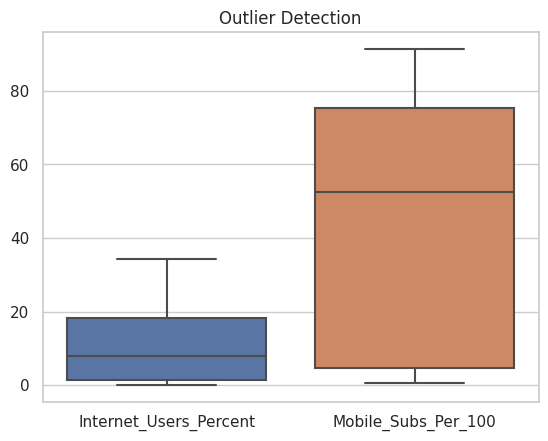

,Year,Internet_Users_Percent,Mobile_Subs_Per_100,Internet_Users_Scaled,Mobile_Subs_Scaled
0,2000,0.0628,0.474803,-1.095748,-1.306662
1,2001,0.2410,0.784352,-1.078200,-1.297444
2,2002,0.2930,0.980824,-1.073080,-1.291593
3,2003,0.3570,1.522320,-1.066778,-1.275468
4,2004,0.4310,1.556920,-1.059491,-1.274437


In [4]:
# Visualize outliers
sns.boxplot(data=df[["Internet_Users_Percent", "Mobile_Subs_Per_100"]])
plt.title("Outlier Detection")
plt.show()

# Optional: Remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]

df = remove_outliers(df, "Internet_Users_Percent")
df = remove_outliers(df, "Mobile_Subs_Per_100")

# Feature Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[["Internet_Users_Percent", "Mobile_Subs_Per_100"]])
df[["Internet_Users_Scaled", "Mobile_Subs_Scaled"]] = scaled_features

df.head()


Step 2: Exploratory Data Analysis (EDA)

We use descriptive statistics and visualizations to explore trends in internet usage and mobile subscriptions over time in Rwanda. Line plots show how these values evolve, and a heatmap is used to show the correlation between the two variables.


Descriptive Stats:
               Year  Internet_Users_Percent  Mobile_Subs_Per_100  \
count    23.000000                23.00000            23.000000   
mean   2011.739130                11.19047            44.353023   
std       7.130073                10.38356            34.335098   
min    2000.000000                 0.06280             0.474803   
25%    2006.000000                 1.33800             4.556655   
50%    2012.000000                 8.02000            52.546700   
75%    2017.500000                18.20000            75.426400   
max    2023.000000                34.20000            91.462300   

       Internet_Users_Scaled  Mobile_Subs_Scaled  
count           2.300000e+01        2.300000e+01  
mean           -2.703152e-16       -2.896234e-17  
std             1.022475e+00        1.022475e+00  
min            -1.095748e+00       -1.306662e+00  
25%            -9.701780e-01       -1.185107e+00  
50%            -3.121978e-01        2.440019e-01  
75%             6.9

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

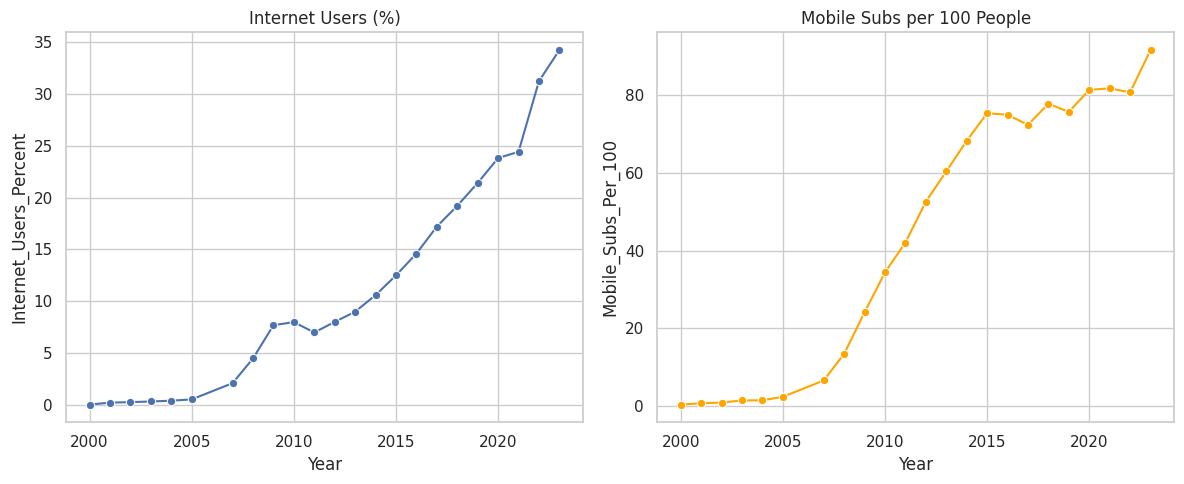

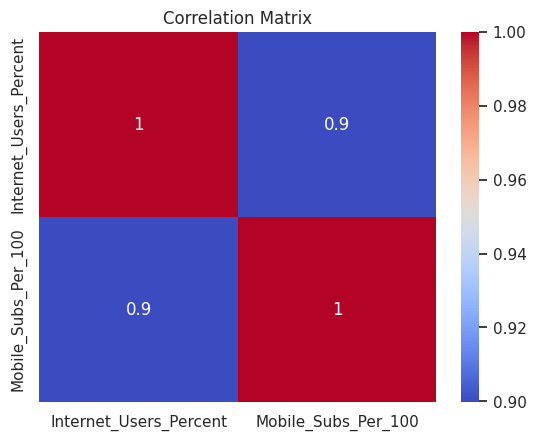

In [5]:
def explore(df):
    print("Descriptive Stats:\n", df.describe())

    # Trend plots
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.lineplot(x="Year", y="Internet_Users_Percent", data=df, marker='o')
    plt.title("Internet Users (%)")

    plt.subplot(1, 2, 2)
    sns.lineplot(x="Year", y="Mobile_Subs_Per_100", data=df, marker='o', color='orange')
    plt.title("Mobile Subs per 100 People")

    plt.tight_layout()
    plt.show()

    # Correlation heatmap
    sns.heatmap(df[["Internet_Users_Percent", "Mobile_Subs_Per_100"]].corr(), annot=True, cmap='coolwarm')
    plt.title("Correlation Matrix")
    plt.show()

explore(df)


Step 3: Regression Model – Predict Internet Usage

We apply a simple Linear Regression model to predict Internet usage (%) based on the year. The model is evaluated using R² score, Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE). A visual comparison between actual and predicted values is shown.


Evaluation:
R² Score: 0.775
MAE: 2.244
RMSE: 3.104


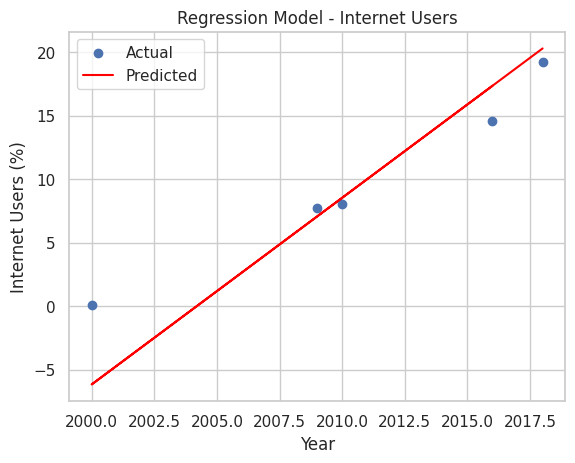

In [6]:
def train_regression(df):
    X = df[["Year"]]
    y = df["Internet_Users_Percent"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print("Evaluation:")
    print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
    print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.3f}")

    plt.scatter(X_test, y_test, label="Actual")
    plt.plot(X_test, y_pred, color='red', label="Predicted")
    plt.xlabel("Year")
    plt.ylabel("Internet Users (%)")
    plt.title("Regression Model - Internet Users")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

model = train_regression(df)


Step 4: Forecast Future Internet Usage (2025–2030)

Using the trained regression model, we forecast the percentage of internet users in Rwanda for the years 2025 through 2030. A plot compares the forecasted trend with the historical data.


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


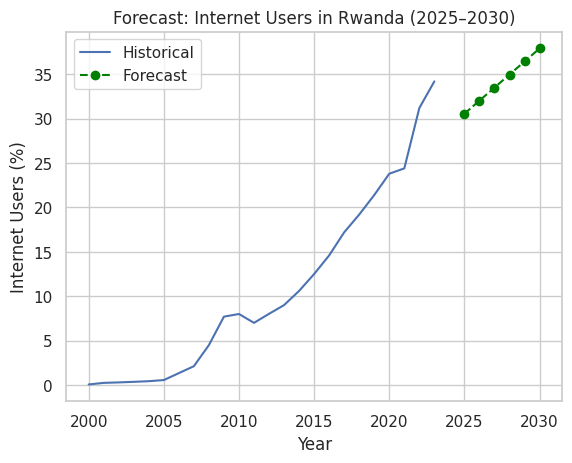

Forecasted Data:
   Year  Predicted_Internet_Users_Percent
0  2025                         30.564289
1  2026                         32.033556
2  2027                         33.502823
3  2028                         34.972090
4  2029                         36.441356
5  2030                         37.910623


In [7]:
def forecast_future(model, start=2025, end=2030):
    future_years = np.arange(start, end + 1).reshape(-1, 1)
    preds = model.predict(future_years)

    future_df = pd.DataFrame({
        "Year": future_years.flatten(),
        "Predicted_Internet_Users_Percent": preds
    })

    plt.plot(df["Year"], df["Internet_Users_Percent"], label="Historical")
    plt.plot(future_df["Year"], future_df["Predicted_Internet_Users_Percent"],
             linestyle='--', marker='o', color='green', label="Forecast")
    plt.title("Forecast: Internet Users in Rwanda (2025–2030)")
    plt.xlabel("Year")
    plt.ylabel("Internet Users (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("Forecasted Data:")
    print(future_df)

forecast_future(model)


Innovation – Forecast Mobile Subscriptions

In addition to internet usage, we build a separate regression model to forecast the number of mobile subscriptions per 100 people in Rwanda from 2025 to 2030. This expands the analysis and provides insight into mobile connectivity trends.


Mobile Model Evaluation:
R² Score: 0.923
MAE: 7.146
RMSE: 8.285


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


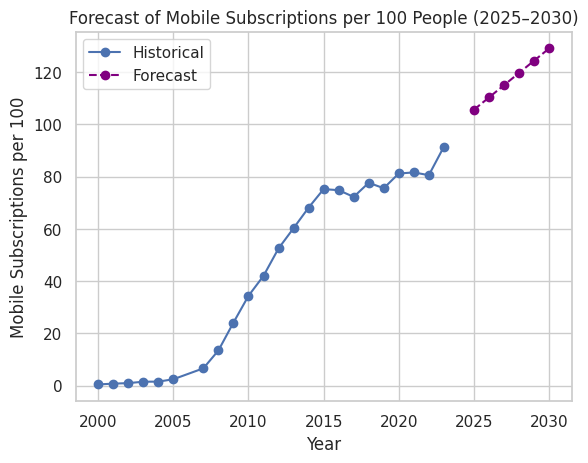

Forecasted Mobile Subscriptions:
   Year  Predicted_Mobile_Subs_Per_100
0  2025                     105.648738
1  2026                     110.340172
2  2027                     115.031607
3  2028                     119.723041
4  2029                     124.414476
5  2030                     129.105911


In [8]:
def forecast_mobile(model=None, df=None):
    # Train regression model for mobile data
    X = df[["Year"]]
    y = df["Mobile_Subs_Per_100"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print("Mobile Model Evaluation:")
    print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
    print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.3f}")

    # Forecast
    future_years = np.arange(2025, 2031).reshape(-1, 1)
    future_preds = model.predict(future_years)

    forecast_df = pd.DataFrame({
        "Year": future_years.flatten(),
        "Predicted_Mobile_Subs_Per_100": future_preds
    })

    # Plot
    plt.plot(df["Year"], df["Mobile_Subs_Per_100"], label="Historical", marker='o')
    plt.plot(forecast_df["Year"], forecast_df["Predicted_Mobile_Subs_Per_100"],
             label="Forecast", linestyle="--", color="purple", marker='o')
    plt.title("Forecast of Mobile Subscriptions per 100 People (2025–2030)")
    plt.xlabel("Year")
    plt.ylabel("Mobile Subscriptions per 100")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("Forecasted Mobile Subscriptions:")
    print(forecast_df)

forecast_mobile(df=df)


##  Innovation – Cluster Years Based on Access Levels

We use K-Means clustering to group years based on similarities in internet usage and mobile subscription rates. This helps us identify different phases in Rwanda’s digital growth and understand how access levels evolved over time.


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


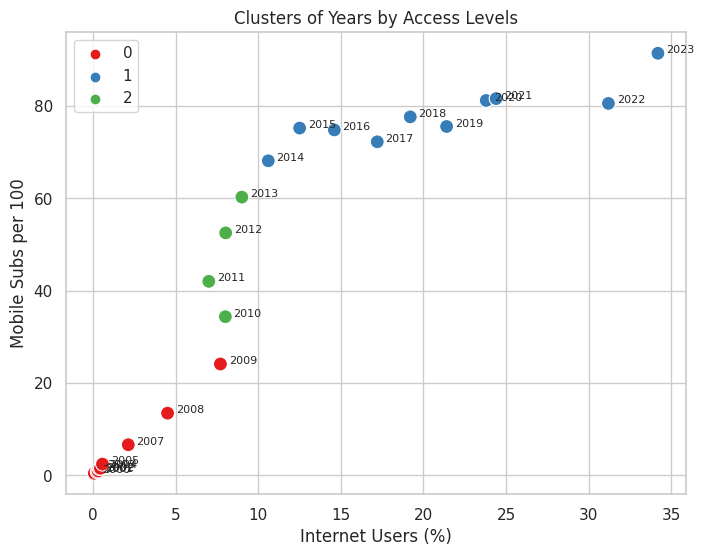

In [9]:
from sklearn.cluster import KMeans

def cluster_years(df, k=3):
    data_for_clustering = df[["Internet_Users_Percent", "Mobile_Subs_Per_100"]]

    kmeans = KMeans(n_clusters=k, random_state=42)
    df["Cluster"] = kmeans.fit_predict(data_for_clustering)

    # Plot the clusters
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x="Internet_Users_Percent",
        y="Mobile_Subs_Per_100",
        hue="Cluster",
        palette="Set1",
        data=df,
        s=100
    )
    for i in range(len(df)):
        plt.text(
            df["Internet_Users_Percent"].iloc[i] + 0.5,
            df["Mobile_Subs_Per_100"].iloc[i],
            str(df["Year"].iloc[i]),
            fontsize=8
        )
    plt.title("Clusters of Years by Access Levels")
    plt.xlabel("Internet Users (%)")
    plt.ylabel("Mobile Subs per 100")
    plt.grid(True)
    plt.legend()
    plt.show()

    return df

df = cluster_years(df)


In [12]:
import pandas as pd

# Load one of the datasets (e.g., internet)
internet_path = '/kaggle/input/rwanda-internet-data/internet_global.csv/API_IT.NET.USER.ZS_DS2_en_csv_v2_112825.csv'
internet_raw = pd.read_csv(internet_path, skiprows=4)

# Show all column names
print(internet_raw.columns)


Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022',
       '2023', '2024', 'Unnamed: 69'],
      dtype='object')
